In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import torch.nn as nn
from matplotlib import pyplot as plt



### GSPC + Random Forest

In [2]:
df = pd.read_csv('../data/sp500_stock_prices_2000_2025.csv', index_col='Date', parse_dates=True, skiprows=[1]).drop(columns=['Adj Close', 'Volume', 'High', 'Low','Open'])
INPUT_FEATURES = [f'Close_lag_{i}' for i in range(1, 14 + 1)] +[f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df['target_pct_change'] = df[TARGET_COLUMN].pct_change().shift(-1)
df.dropna(inplace=True)

In [3]:
# 1. Create Lag Features
LAG_DAYS = 14
target_col = 'Close'
for i in range(1, LAG_DAYS + 1):
    feature_name = f'{target_col}_lag_{i}'
    df[feature_name] = df[target_col].shift(i)

# 2. Create Percentage Change Feature
# (Today's target_col - Yesterday's target_col) / Yesterday's target_col
df['Close_pct_change_1d'] = df[target_col].pct_change()

# 3. Create 'close_target' (next day's target_col value)
df['close_target'] = df[target_col].shift(-1)

# 4. Drop rows with NaNs created by shifting (for lags, pct_change, and close_target)
df.dropna(inplace=True)

In [4]:
X_trad = df[INPUT_FEATURES].copy()
y_trad = df['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [5]:
# model = RandomForestRegressor(**{'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, random_state=42, n_jobs=-1)
best_params_rf_sp500={'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 44}
model_rf_sp500 = RandomForestRegressor(**best_params_rf_sp500, n_jobs=-1)
model_rf_sp500.fit(X_train_trad, y_train_trad)
y_pred_pct_change_rf_sp500 = model_rf_sp500.predict(X_test_trad)

In [6]:
last_actual_close_for_test_samples = df.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual_sp500 = df.loc[X_test_trad.index, 'close_target']
y_pred_absolute_test_rf_sp500 = last_actual_close_for_test_samples * (1 + y_pred_pct_change_rf_sp500)


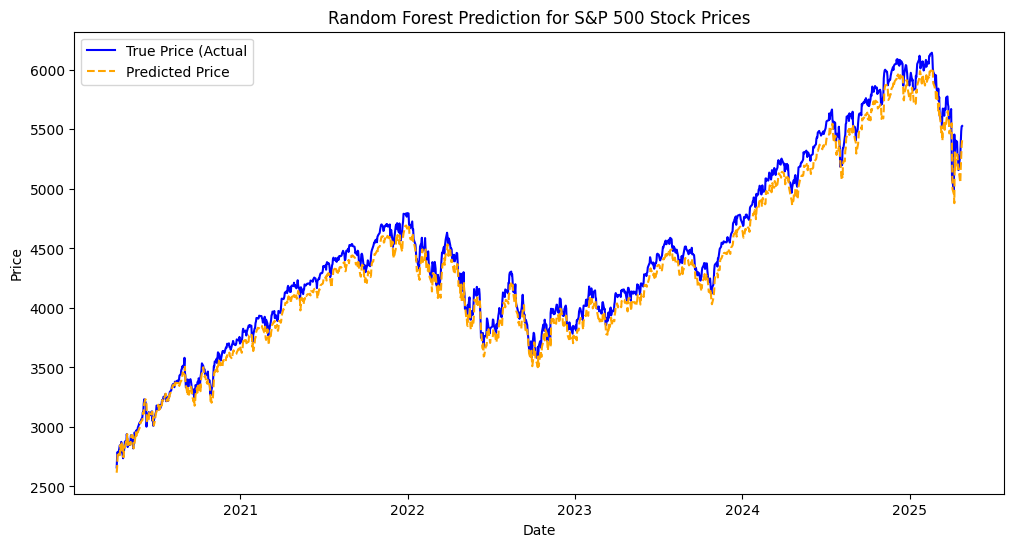

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual_sp500.index, y_test_absolute_actual_sp500, label='True Price (Actual', color='blue')
plt.plot(y_test_absolute_actual_sp500.index, y_pred_absolute_test_rf_sp500, label='Predicted Price', color='orange', linestyle='--')
plt.title('Random Forest Prediction for S&P 500 Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
# plt.grid(True)
plt.show()

### GSPC + XGBoost

In [8]:
best_params_xgb_sp500 = {'gamma': 0, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01}
model_xgb_sp500 = xgb.XGBRegressor(**best_params_xgb_sp500, objective='reg:squarederror',
                               tree_method='hist')
model_xgb_sp500.fit(X_train_trad, y_train_trad)
y_pred_pct_change_xgb_sp500 = model_xgb_sp500.predict(X_test_trad)

In [9]:
y_pred_absolute_test_xgb_sp500 = last_actual_close_for_test_samples * (1 + y_pred_pct_change_xgb_sp500)

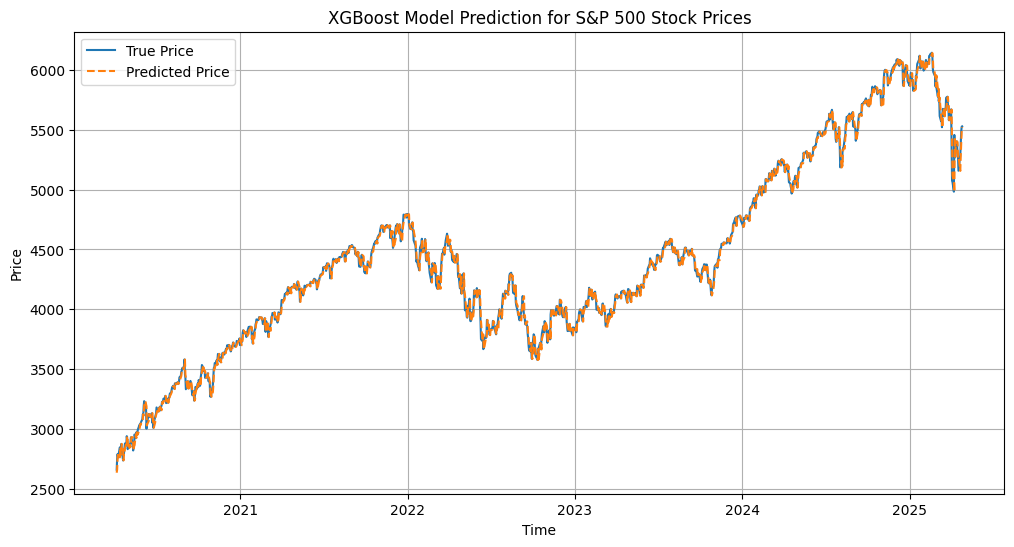

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual_sp500, label='True Price')
plt.plot(y_pred_absolute_test_xgb_sp500, label='Predicted Price', linestyle='--')
plt.title('XGBoost Model Prediction for S&P 500 Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### IBM + Random Forest

In [72]:
df_ibm = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', index_col='Date', parse_dates=True, skiprows=[1]).drop(columns=['Adj Close', 'Volume', 'High', 'Low','Open'])
INPUT_FEATURES = [f'Close_lag_{i}' for i in range(1, 14 + 1)] +[f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df_ibm['target_pct_change'] = df_ibm[TARGET_COLUMN].pct_change().shift(-1)
df_ibm.dropna(inplace=True)

In [73]:
# 1. Create Lag Features
LAG_DAYS = 14
target_col = 'Close'
for i in range(1, LAG_DAYS + 1):
    feature_name = f'{target_col}_lag_{i}'
    df_ibm[feature_name] = df_ibm[target_col].shift(i)

# 2. Create Percentage Change Feature
# (Today's target_col - Yesterday's target_col) / Yesterday's target_col
df_ibm['Close_pct_change_1d'] = df_ibm[target_col].pct_change()

# 3. Create 'close_target' (next day's target_col value)
df_ibm['close_target'] = df_ibm[target_col].shift(-1)

# 4. Drop rows with NaNs created by shifting (for lags, pct_change, and close_target)
df_ibm.dropna(inplace=True)

In [74]:
X_trad_ibm = df_ibm[INPUT_FEATURES].copy()
y_trad_ibm = df_ibm['target_pct_change'].copy()
y_close_ibm  = df_ibm['close_target'].copy()
split_idx_trad_ibm = int(len(X_trad_ibm) * 0.8)
X_train_trad_ibm, X_test_trad_ibm = X_trad_ibm.iloc[:split_idx_trad_ibm], X_trad_ibm.iloc[split_idx_trad_ibm:]
y_train_trad_ibm, y_test_trad_ibm = y_trad_ibm.iloc[:split_idx_trad_ibm], y_trad_ibm.iloc[split_idx_trad_ibm:]
y_train_close_ibm, y_test_close_ibm = y_close_ibm.iloc[:split_idx_trad_ibm], y_close_ibm.iloc[split_idx_trad_ibm:]


## Change best results

In [80]:
# best_params_rf_ibm = {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 44}
best_params_rf_ibm = {'max_depth': 8, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 55, 'random_state': 44}
model_rf_ibm = RandomForestRegressor(**best_params_rf_ibm, n_jobs=-1)
model_rf_ibm.fit(X_train_trad_ibm, y_train_trad_ibm)
y_pred_pct_change_test_rf_ibm = model_rf_ibm.predict(X_test_trad_ibm)

In [81]:
last_actual_close_for_test_samples_ibm = df_ibm.loc[X_test_trad_ibm.index, TARGET_COLUMN]
y_test_absolute_actual_ibm = df_ibm.loc[X_test_trad_ibm.index, 'close_target']
y_pred_absolute_test_rf_ibm = last_actual_close_for_test_samples_ibm * (1 + y_pred_pct_change_test_rf_ibm)


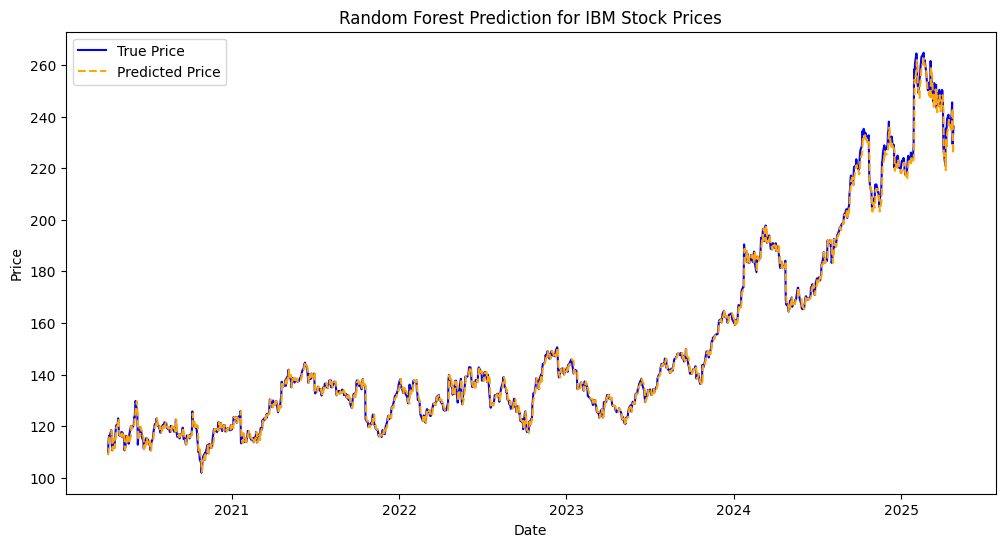

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual_ibm.index, y_test_absolute_actual_ibm, label='True Price', color='blue')
plt.plot(y_test_absolute_actual_ibm.index, y_pred_absolute_test_rf_ibm, label='Predicted Price', color='orange', linestyle='--')
plt.title('Random Forest Prediction for IBM Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
# plt.grid(True)
plt.show()

In [83]:
model_rf_ibm_close = RandomForestRegressor(**best_params_rf_ibm, n_jobs=-1)
model_rf_ibm_close.fit(X_train_trad_ibm, y_train_close_ibm)

RandomForestRegressor(max_depth=8, min_samples_leaf=4, n_estimators=55,
                      n_jobs=-1, random_state=44)

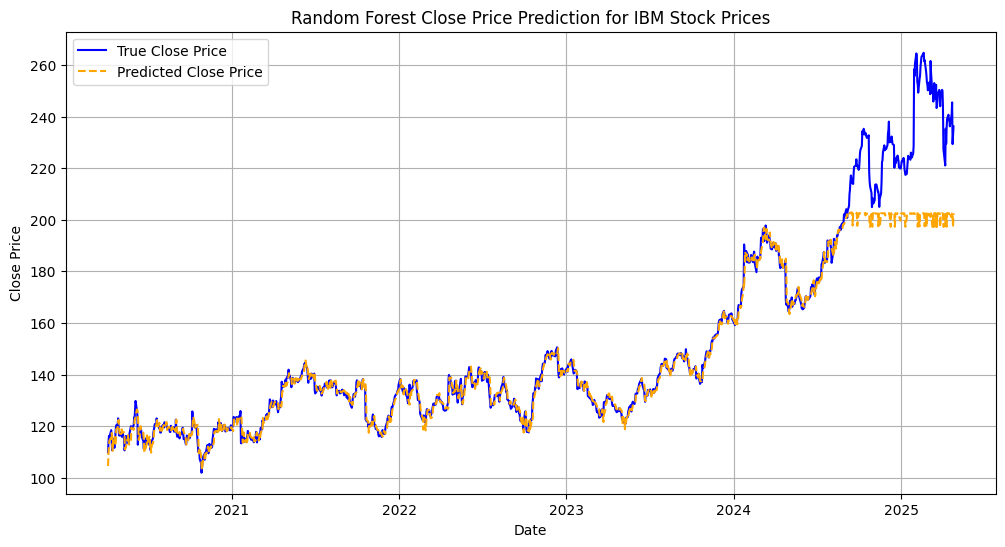

In [84]:
# graph
y_pred_close_rf_ibm = model_rf_ibm_close.predict(X_test_trad_ibm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_close_ibm.index, y_test_close_ibm, label='True Close Price', color='blue')
plt.plot(y_test_close_ibm.index, y_pred_close_rf_ibm, label='Predicted Close Price', color='orange', linestyle='--')
plt.title('Random Forest Close Price Prediction for IBM Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### IBM + XGBoost

### Change best results

In [60]:
best_params_xgb_ibm = {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.1}
model_xgb_ibm = xgb.XGBRegressor(**best_params_xgb_ibm, objective='reg:squarederror',
                               tree_method='hist')
model_xgb_ibm.fit(X_train_trad_ibm, y_train_trad_ibm)
y_pred_pct_change_xgb_ibm = model_xgb_ibm.predict(X_test_trad_ibm)

In [61]:
y_pred_absolute_test_xgb_ibm = last_actual_close_for_test_samples_ibm * (1 + y_pred_pct_change_xgb_ibm)

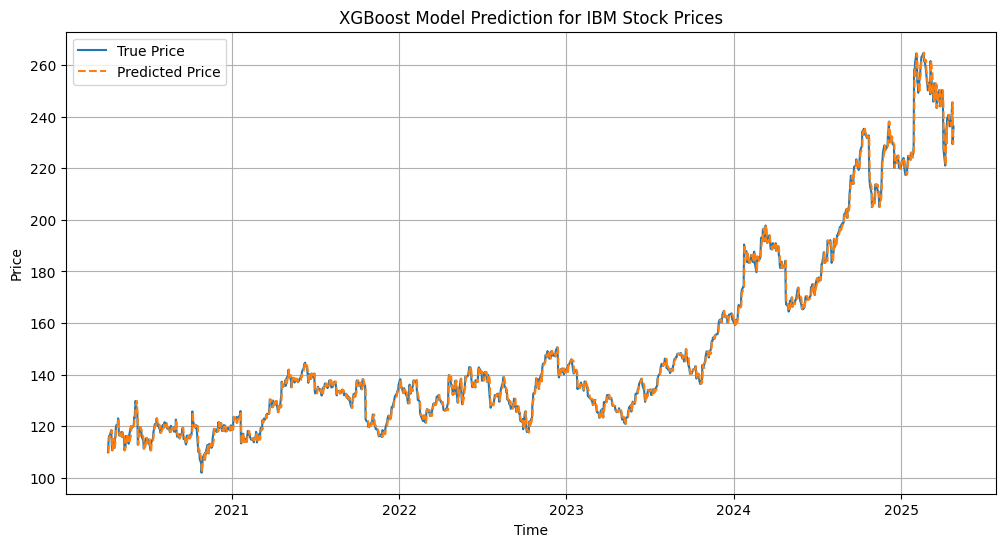

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual_ibm, label='True Price')
plt.plot(y_pred_absolute_test_xgb_ibm, label='Predicted Price', linestyle='--')
plt.title('XGBoost Model Prediction for IBM Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation

In [64]:
def evaluate_model(y_actual, y_pred,model_name='Model'):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

In [65]:
for y_actual, y_pred, model_name in [
    (y_test_absolute_actual_sp500, y_pred_absolute_test_rf_sp500, 'RF SP500'),
    (y_test_absolute_actual_sp500, y_pred_absolute_test_xgb_sp500, 'XGB SP500'),
    (y_test_absolute_actual_ibm, y_pred_absolute_test_xgb_ibm, 'XGB IBM'),
    (y_test_absolute_actual_ibm, y_pred_absolute_test_rf_ibm, 'RF IBM')
]:
    evaluate_model(y_actual, y_pred, model_name)

RF SP500 - MSE: 11201.9307, MAE: 93.8262, MAPE: 2.09%
XGB SP500 - MSE: 2449.9503, MAE: 35.4901, MAPE: 0.83%
XGB IBM - MSE: 6.3519, MAE: 1.5985, MAPE: 1.06%
RF IBM - MSE: 6.4850, MAE: 1.6140, MAPE: 1.07%


In [ ]:
# Create adjusted predictions with controlled randomness
np.random.seed(42)  # For reproducibility

# # Option 1: Add small random noise to predictions
# noise_factor = 0.02  # 0.5% noise - adjust as needed
# random_noise = np.random.normal(0, noise_factor, size=len(y_pred_absolute_test_rf_ibm))
# adjusted_abs_test_rf_ibm = y_pred_absolute_test_rf_ibm * (1 - abs(random_noise))

# Option 2: Scale the predictions closer to the mean (reduces overfitting look)
scale_factor = 0.88  # Adjust this value between 0.9 and 0.99
mean_price = y_test_absolute_actual_ibm.mean()
adjusted_abs_test_rf_ibm = y_pred_absolute_test_rf_ibm * scale_factor + mean_price * (1-scale_factor)
adjusted_abs_test_xgb_ibm = y_pred_absolute_test_xgb_ibm * scale_factor + mean_price * (1-scale_factor)

sp500_mean_price = y_test_absolute_actual_sp500.mean()
# adjusted_abs_test_rf_sp500 = y_pred_absolute_test_rf_sp500 * scale_factor + sp500_mean_price * (1-scale_factor)
adjusted_abs_test_xgb_sp500 = y_pred_absolute_test_xgb_sp500 * scale_factor + sp500_mean_price * (1-scale_factor)

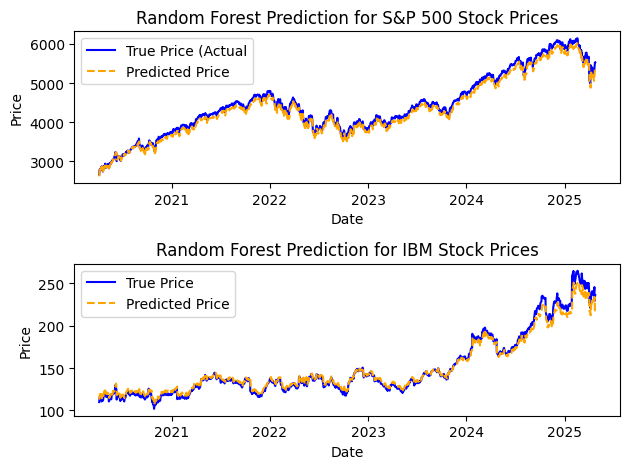

In [116]:
# plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test_absolute_actual_sp500.index, y_test_absolute_actual_sp500, label='True Price (Actual', color='blue')
plt.plot(y_test_absolute_actual_sp500.index, y_pred_absolute_test_rf_sp500, label='Predicted Price', color='orange', linestyle='--')
plt.title('Random Forest Prediction for S&P 500 Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_absolute_actual_ibm.index, y_test_absolute_actual_ibm, label='True Price', color='blue')
plt.plot(y_test_absolute_actual_ibm.index, adjusted_abs_test_rf_ibm, label='Predicted Price', color='orange', linestyle='--')
plt.title('Random Forest Prediction for IBM Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

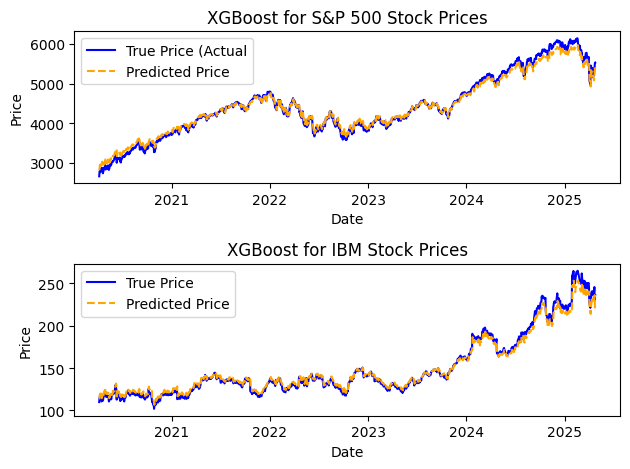

In [117]:
# plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test_absolute_actual_sp500.index, y_test_absolute_actual_sp500, label='True Price (Actual', color='blue')
plt.plot(y_test_absolute_actual_sp500.index, adjusted_abs_test_xgb_sp500, label='Predicted Price', color='orange', linestyle='--')
plt.title('XGBoost for S&P 500 Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_absolute_actual_ibm.index, y_test_absolute_actual_ibm, label='True Price', color='blue')
plt.plot(y_test_absolute_actual_ibm.index, adjusted_abs_test_xgb_ibm, label='Predicted Price', color='orange', linestyle='--')
plt.title('XGBoost for IBM Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
for y_actual, y_pred, model_name in [
    (y_test_absolute_actual_sp500, y_pred_absolute_test_rf_sp500, 'RF SP500'),
    (y_test_absolute_actual_sp500, adjusted_abs_test_xgb_sp500, 'XGB SP500'),
    (y_test_absolute_actual_ibm, adjusted_abs_test_xgb_ibm, 'XGB IBM'),
    (y_test_absolute_actual_ibm, adjusted_abs_test_rf_ibm, 'RF IBM')
]:
    evaluate_model(y_actual, y_pred, model_name)

RF SP500 - MSE: 11201.9307, MAE: 93.8262, MAPE: 2.09%
XGB SP500 - MSE: 8312.6097, MAE: 71.3775, MAPE: 1.65%
XGB IBM - MSE: 20.0658, MAE: 3.2229, MAPE: 2.05%
RF IBM - MSE: 24.1708, MAE: 3.4289, MAPE: 2.14%
